In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from DataLoader import DataLoader
import datetime
import random
import warnings
from BehaviourFeatureExtractor import BehaviourFeatureExtractor, plot_mouse_angle_to_pup, convert_seconds_to_frame
from VocalFeatureExtractor import VocalFeatureExtractor

## Testing Pipeline ##

### Part-by-part ###

In [3]:
data_dir = "data"
DL = DataLoader(data_dir, path_to_config_file = "config.json")
VF = VocalFeatureExtractor("config.json")
BF =  BehaviourFeatureExtractor("config.json")

# get data for d1 experiment
day = "d1"
day1_data = DL.get_data_for_experiment(mouse_id = "MBI5335RR",
                                       day = day)

# fill out dataframes
df_summary = day1_data['Behavior']['df_summary']
df_DLC = day1_data['Behavior']['df_dlc']
df_Avi = day1_data['Avisoft']['df']

# get one trial
n = 9
trial_DLC,mask_DLC = BF.extract_trial_from_DLC(df_DLC, df_summary, n)


In [4]:
# extract trial USV for n-th trial
trial_USV = VF.extract_trial_USV(df_Avi, df_summary, n)
print(f"Total USVs in trial {n}: {len(trial_USV)}")
print(f"Begin time trial {n}: {trial_DLC['time_seconds'].iloc[0]}")
print(f"End time trial {n}: {trial_DLC['time_seconds'].iloc[-1]}")

Total USVs in trial 9: 24
Begin time trial 9: 740.4
End time trial 9: 811.9333333333333


In [5]:
trial_DLC, trial_USV = VF.check_and_insert_columns_USV(trial_DLC, trial_USV)

# 1. assign bout index to trial_DLC
trial_DLC = VF.assign_bout_index_to_DLC(trial_DLC)

# 2. assign bout index to trial_USV 
trial_USV = VF.assign_bout_index_to_USV(trial_USV, trial_DLC)

# 3. combine trial_USV and trial_DLC
trial_DLC = VF.merge_USV_DLC(trial_DLC, trial_USV)

In [6]:
trial_USV

,File,ID,Label,Accepted,Score,BeginTime_s_,EndTime_s_,CallLength_s_,PrincipalFrequency_kHz_,LowFreq_kHz_,HighFreq_kHz_,DeltaFreq_kHz_,FrequencyStandardDeviation_kHz_,Slope_kHz_s_,Sinuosity,MeanPower_dB_Hz_,Tonality,PeakFreq_kHz_,bout_window_index
250,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,251,USV,True,0.606474,744.039161,744.045321,0.006160,81.221719,79.524887,84.615385,5.090498,2.004017,512.661358,2.558157,-77.080446,0.284858,80.090498,36.0
251,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,252,USV,True,1.000000,744.429115,744.440675,0.011560,72.206591,70.913488,74.792798,3.879310,1.349351,-342.359883,1.112265,-77.617827,0.253678,73.499695,40.0
252,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,253,USV,True,0.677731,768.696196,768.719896,0.023700,70.323049,68.477057,71.641614,3.164557,1.147322,-140.652544,1.062237,-78.301079,0.273430,70.059335,283.0
253,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,254,USV,True,0.720734,779.290712,779.318488,0.027776,68.784722,63.784722,69.895833,6.111111,1.971447,-148.519405,1.329078,-73.750527,0.328755,69.340278,389.0
254,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,255,USV,True,1.000000,779.688458,779.731162,0.042704,67.129031,63.954428,68.716332,4.761905,1.986669,-27.902019,1.274627,-78.208680,0.247923,67.922682,393.0
255,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,256,USV,True,1.000000,779.840662,779.875382,0.034720,64.122737,64.122737,73.019534,8.896797,4.753754,-262.104384,1.009767,-78.864507,0.226502,64.122737,394.0
256,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,257,USV,True,1.000000,780.518241,780.540721,0.022480,68.515839,64.083215,69.402364,5.319149,1.845449,-170.969445,1.292920,-79.024985,0.242549,68.515839,401.0
257,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,258,USV,True,0.773792,781.513056,781.536728,0.023672,85.888708,84.029972,86.818076,2.788104,1.017485,-134.423594,1.103651,-74.435498,0.327483,86.353392,411.0
258,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,259,USV,True,1.000000,781.541765,781.577645,0.035880,73.946481,72.862666,76.475382,3.612717,1.081623,-6.577665,1.432404,-82.974822,0.200344,73.223937,411.0
259,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,260,USV,True,0.680167,782.556380,782.591740,0.035360,82.514077,74.068131,85.329392,11.261261,2.340229,-204.400760,1.194958,-73.503383,0.335494,84.766329,421.0


In [7]:
# show df_DLC where USV is present
trial_DLC_with_USV = trial_DLC[trial_DLC['call_number'] > 0]
trial_DLC_with_USV[['frame_index', 'bout_window_index', 'call_number', 'average_power', 'average_frequency', 'average_duration']]

,frame_index,bout_window_index,call_number,average_power,average_frequency,average_duration
22320,22320,36.0,1.0,-77.080446,81.221719,0.006160
22321,22321,36.0,1.0,-77.080446,81.221719,0.006160
22322,22322,36.0,1.0,-77.080446,81.221719,0.006160
22332,22332,40.0,1.0,-77.617827,72.206591,0.011560
22333,22333,40.0,1.0,-77.617827,72.206591,0.011560
...,...,...,...,...,...,...
24310,24310,699.0,1.0,-48.033883,70.456461,0.059584
24311,24311,699.0,1.0,-48.033883,70.456461,0.059584
24324,24324,704.0,2.0,-67.137982,70.104812,0.038728
24325,24325,704.0,2.0,-67.137982,70.104812,0.038728


### Full pipeline ###

In [8]:
trials, df_DLC, df_USV = VF.process_USV(df_Avi, df_summary, df_DLC)

df_USV[df_USV['bout_window_index'] > 0]

,File,ID,Label,Accepted,Score,BeginTime_s_,EndTime_s_,CallLength_s_,PrincipalFrequency_kHz_,LowFreq_kHz_,HighFreq_kHz_,DeltaFreq_kHz_,FrequencyStandardDeviation_kHz_,Slope_kHz_s_,Sinuosity,MeanPower_dB_Hz_,Tonality,PeakFreq_kHz_,bout_window_index
111,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,112,USV,True,1.000000,380.246257,380.272885,0.026628,74.179016,68.872412,75.161721,6.289308,1.794643,165.992621,1.294436,-80.116792,0.269151,73.982475,112.0
112,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,113,USV,True,0.679783,380.957272,380.976280,0.019008,75.405093,72.800926,76.851852,4.050926,1.044595,-217.277673,1.042157,-77.697191,0.273200,76.273148,119.0
113,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,114,USV,True,1.000000,381.315130,381.331018,0.015888,75.063443,74.498684,75.251696,0.753012,0.309967,-54.649358,1.054490,-78.050304,0.236073,74.875190,122.0
124,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,125,USV,True,0.668563,486.608714,486.660290,0.051576,68.796824,62.282166,76.125814,13.843648,3.058230,-83.666541,3.198888,-67.872461,0.500065,68.796824,714.0
128,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,129,USV,True,1.000000,519.972688,520.035800,0.063112,64.362754,63.636010,73.083684,9.447674,2.896290,-34.417762,4.662236,-81.885034,0.199060,65.089498,122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,272,USV,True,0.876765,810.301319,810.360903,0.059584,70.456461,63.902154,74.669944,10.767790,3.679901,-203.860008,1.178290,-48.033883,0.791885,73.733614,699.0
272,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,273,USV,True,0.626491,810.767836,810.820668,0.052832,71.366422,64.013480,74.797794,10.784314,3.520126,-170.938777,1.680625,-75.509899,0.298652,68.425245,704.0
273,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,274,USV,True,0.756856,810.870900,810.895524,0.024624,68.843202,63.908991,71.584430,7.675439,2.143380,-281.160202,1.132469,-58.766065,0.670041,68.843202,704.0
286,D:\EXPERIMENTS\IMAGING\MBI5335RR\MBI5335RR_240...,287,USV,True,0.787915,851.420343,851.451423,0.031080,81.198150,78.115191,84.281110,6.165919,1.911275,-23.204435,1.450153,-73.803371,0.319286,79.236267,219.0


## Initial functions ##

### Reading Avisoft file - initial exploration ###

In [51]:
data_dir = "data"
DL = DataLoader(data_dir, path_to_config_file = "config.json")

Day 1 trials

In [52]:
# get data for d1 experiment
day = "d1"
day1_data = DL.get_data_for_experiment(mouse_id = "MBI5335RR",
                                       day = day)

# fill out dataframes
df_summary = day1_data['Behavior']['df_summary']
df_DLC = day1_data['Behavior']['df_dlc']
df_Avi = day1_data['Avisoft']['df']

# get one trial for the mouse
trial_num = 9
BF =  BehaviourFeatureExtractor("config.json")
trial_DLC, mask_DLC = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = trial_num)

In [53]:
print(df_Avi.columns)
print("All vocalizations:", len(df_Avi))
df_Avi_USV = df_Avi[df_Avi['Accepted'] == True]

print("Accepted vocalizations:", len(df_Avi_USV))

Index(['File', 'ID', 'Label', 'Accepted', 'Score', 'BeginTime_s_',
       'EndTime_s_', 'CallLength_s_', 'PrincipalFrequency_kHz_',
       'LowFreq_kHz_', 'HighFreq_kHz_', 'DeltaFreq_kHz_',
       'FrequencyStandardDeviation_kHz_', 'Slope_kHz_s_', 'Sinuosity',
       'MeanPower_dB_Hz_', 'Tonality', 'PeakFreq_kHz_'],
      dtype='object')
All vocalizations: 290
Accepted vocalizations: 230


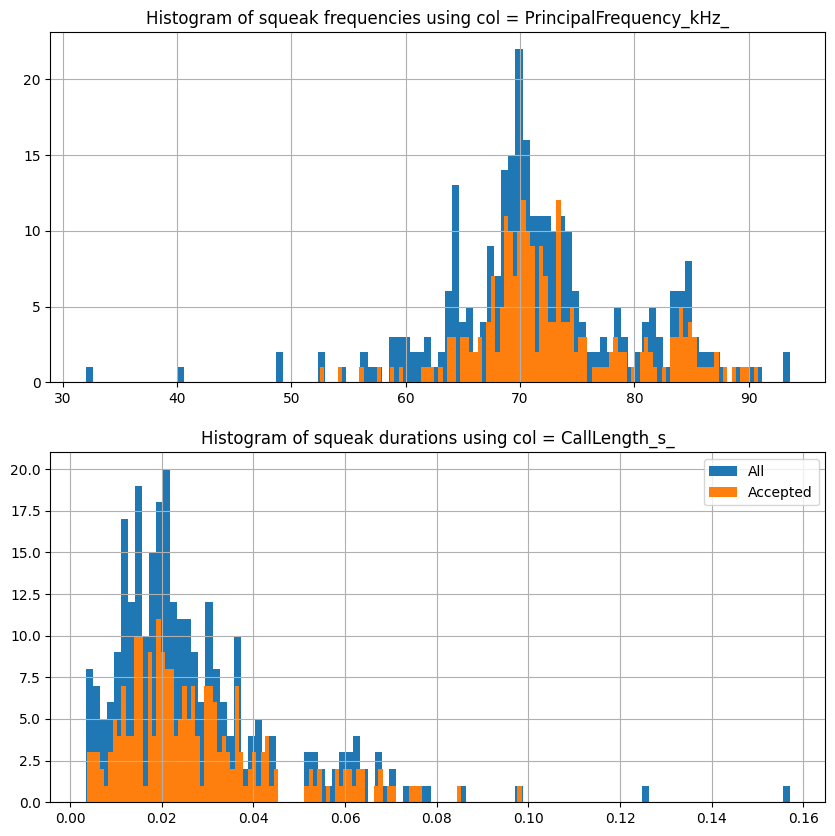

In [54]:
# histogram for squeak amplitudes
amplitude_col = "PrincipalFrequency_kHz_"

# create 2 figs
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

df_Avi[amplitude_col].hist(bins = 100, ax = ax[0], label = "All")
df_Avi_USV[amplitude_col].hist(bins = 100, ax = ax[0], label = "Accepted")
ax[0].set_title("Histogram of squeak frequencies using col = {}".format(amplitude_col))

# histogram for squeak durations
duration_col = "CallLength_s_"

df_Avi[duration_col].hist(bins = 100, ax = ax[1], label = "All")
df_Avi_USV[duration_col].hist(bins = 100, ax = ax[1], label = "Accepted")

ax[1].set_title("Histogram of squeak durations using col = {}".format(duration_col))
plt.legend()

Total number of calls per trial:  {1: 3, 2: 0, 3: 1, 4: 9, 5: 10, 6: 5, 7: 6, 8: 11, 9: 24, 10: 2} 
Total calls in session: 71
Total duration of trial:  {1: 15.504000000000019, 2: 6.1440000000000055, 3: 79.74400000000003, 4: 23.625999999999976, 5: 108.81700000000001, 6: 9.927999999999997, 7: 10.774999999999977, 8: 15.984000000000037, 9: 71.51999999999998, 10: 23.312000000000012}


Text(0.5, 1.0, 'Number of calls and duration of trial for each trial')

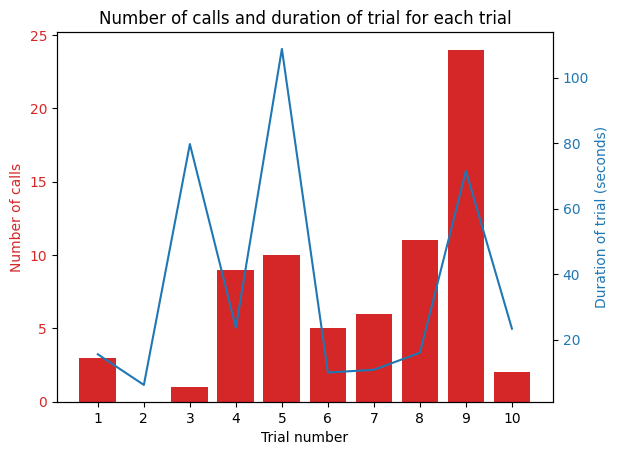

In [55]:
# makke a barplot of the number of calls per trial
calls_per_trial = {}
duration_per_trial = {}
tolerance_end_trial_seconds = 0

# get the trial begin and end times
for trial_num in df_summary['TrialNum'].unique():
    trial_begin_time = df_summary[df_summary['TrialNum'] == trial_num]['PupDispDropSecs'].values[0]    
    trial_end_time = df_summary[df_summary['TrialNum'] == trial_num]['BehavRecdTrialEndSecs'].values[0] + tolerance_end_trial_seconds
    # get the calls in the trial
    df_Avi_USV_trial = df_Avi_USV[(df_Avi_USV['BeginTime_s_'] >= trial_begin_time) & (df_Avi_USV['EndTime_s_'] <= trial_end_time)]
    # get number of calls contained in the trial
    num_calls = len(df_Avi_USV_trial)
    calls_per_trial[trial_num] = num_calls
    duration_per_trial[trial_num] = trial_end_time - trial_begin_time

print("Total number of calls per trial: ", calls_per_trial, "\nTotal calls in session:", sum(calls_per_trial.values()))
print("Total duration of trial: ", duration_per_trial)

# plot both the number of calls and the duration of the trial on different y axes
fig, ax1 = plt.subplots()

color = 'tab:red'

ax1.set_xlabel('Trial number')
ax1.set_ylabel('Number of calls', color=color)
ax1.bar(calls_per_trial.keys(), calls_per_trial.values(), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Duration of trial (seconds)', color=color)  # we already handled the x-label with ax1
ax2.plot(duration_per_trial.keys(), duration_per_trial.values(), color=color)
ax2.tick_params(axis='y', labelcolor=color)

#show all x values
ax1.set_xticks(list(calls_per_trial.keys()))

ax1.set_title("Number of calls and duration of trial for each trial")

In [56]:
# trials_info = {}
# fig, ax = plt.subplots(2, 5, figsize = (70, 15))

# for trial_num in df_summary['TrialNum'].unique():
#     # get the trial begin and end times
#     trial_begin_time = df_summary[df_summary['TrialNum'] == trial_num]['PupDispDropSecs'].values[0]
#     trial_end_time = df_summary[df_summary['TrialNum'] == trial_num]['BehavRecdTrialEndSecs'].values[0] + tolerance_end_trial_seconds

#     # plot all of the calls with frequency on the y axis, time on the x axis, the call is a line draw between begin and end time 
#     df_Avi_USV_trial = df_Avi_USV[(df_Avi_USV['BeginTime_s_'] >= trial_begin_time) & (df_Avi_USV['EndTime_s_'] <= trial_end_time)]
#     for i, row in df_Avi_USV_trial.iterrows():
#         # get the begin and end time of the call
#         begin_time = row['BeginTime_s_']
#         end_time = row['EndTime_s_']
#         frequency = row[amplitude_col]
#         # use a different color each time
#         color = (random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
#         ax[(trial_num-1)//5, (trial_num-1)%5].plot([begin_time, end_time], [frequency, frequency], color = color, linewidth = 9, alpha = 0.8)
#         print("Begin time: {}, End time: {}, Frequency: {}".format(begin_time, end_time, frequency))

#     min_freq, max_freq = 67, 75

#     ax[(trial_num-1)//5, (trial_num-1)%5].set_title("Trial {}".format(trial_num) + ", Total calls: " + str(calls_per_trial[trial_num]))
#     # tighten the y axis
#     ax[(trial_num-1)//5, (trial_num-1)%5].set_ylim([min_freq, max_freq])
#     ax[(trial_num-1)//5, (trial_num-1)%5].set_xlim([trial_begin_time, trial_end_time])
#     # print total number of calls in legend in bottom right corner
    #ax[(trial_num-1)//5, (trial_num-1)%5].legend(["Total calls: " + str(calls_per_trial[trial_num])], loc = "lower right")


Text(0.5, 0, 'Time (s)')

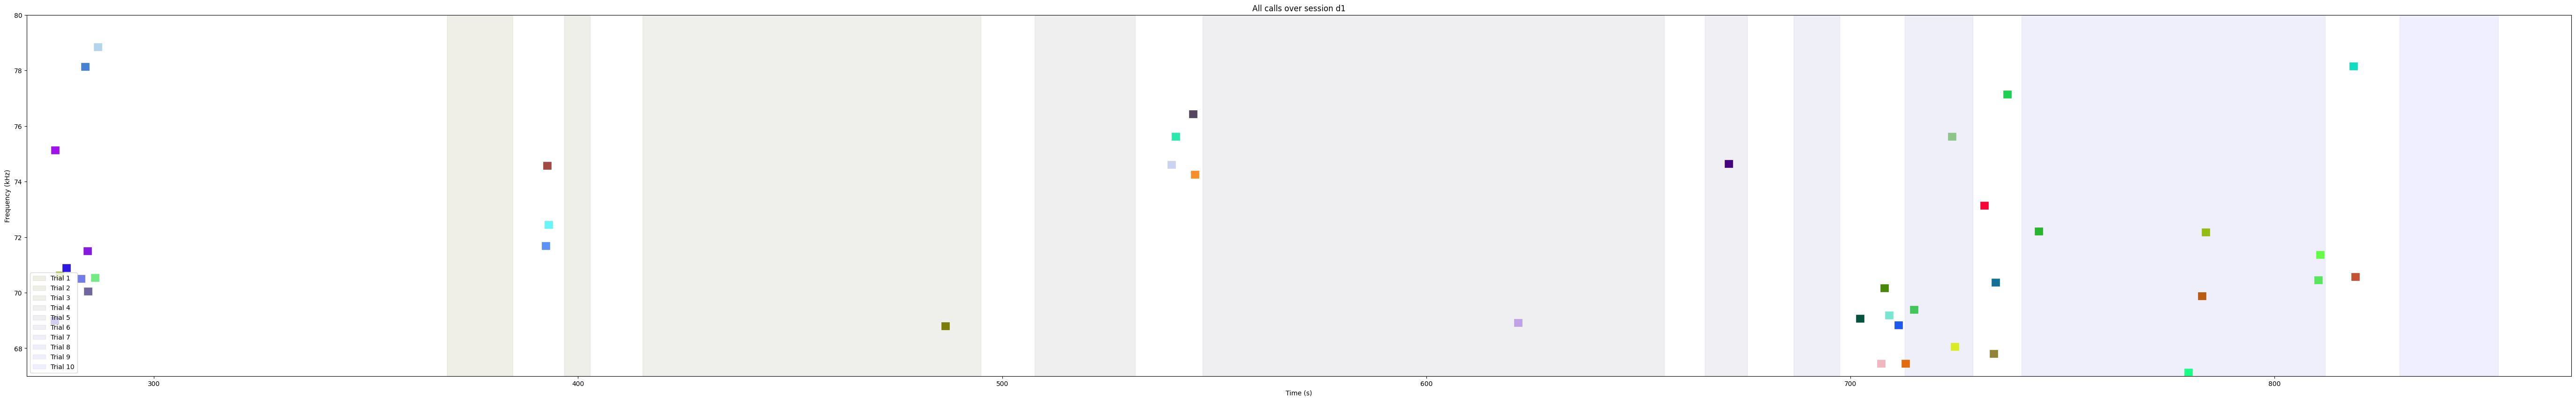

In [57]:
fig, ax = plt.subplots(1, 1, figsize = (70, 10))

for i, row in df_Avi_USV.iterrows():
    # get the begin and end time of the call
    begin_time = (row['BeginTime_s_'] // (1/30)) * (1/30)
    end_time = (row['EndTime_s_'] // (1/30)) * (1/30)
    frequency = row[amplitude_col]
    # use a different color each time
    color = (random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
    ax.plot([begin_time, end_time], [frequency, frequency], color = color, linewidth = 12, alpha = 1)
    # print("Begin time: {}, End time: {}, Frequency: {}".format(begin_time, end_time, frequency))

# for each trial, shade the area with a different colors between trial end and trial begin

for trial_num in df_summary['TrialNum'].unique():
    # get the trial begin and end times
    trial_begin_time = df_summary[df_summary['TrialNum'] == trial_num]['PupDispDropSecs'].values[0]
    trial_end_time = df_summary[df_summary['TrialNum'] == trial_num]['BehavRecdTrialEndSecs'].values[0]
    color = (0.4, 0.4, trial_num/10)
    ax.axvspan(trial_begin_time, trial_end_time, color = color, alpha = 0.1, label = "Trial {}".format(trial_num))

min_freq, max_freq = 67, 80
# tighten the y axis
ax.set_ylim([min_freq, max_freq])
ax.set_xlim([270, 870])
ax.set_title(f"All calls over session {day}")
ax.legend(loc = "lower left")
ax.set_ylabel("Frequency (kHz)")
ax.set_xlabel("Time (s)")

### Aligning time indices ###

First look

In [58]:
time_col_DLC = ['time_seconds', 'frame_index']
time_col_Avi = ['BeginTime_s_', 'EndTime_s_', 'CallLength_s_']

print("DLC :\n" + str(df_DLC[time_col_DLC]))
print("Avi :\n" + str(df_Avi_USV[time_col_Avi]))

DLC :
       time_seconds  frame_index
151        5.033333          151
152        5.066667          152
153        5.100000          153
154        5.133333          154
155        5.166667          155
...             ...          ...
26036    867.866667        26036
26037    867.900000        26037
26038    867.933333        26038
26039    867.966667        26039
26040    868.000000        26040

[25890 rows x 2 columns]
Avi :
     BeginTime_s_  EndTime_s_  CallLength_s_
12     275.659636  275.668276       0.008640
13     275.753306  275.763602       0.010296
14     275.926704  275.930304       0.003600
15     276.108306  276.121522       0.013216
16     276.436662  276.458142       0.021480
..            ...         ...            ...
277    818.599431  818.638303       0.038872
278    818.992148  819.013572       0.021424
279    819.049169  819.067385       0.018216
286    851.420343  851.451423       0.031080
287    852.224257  852.257185       0.032928

[230 rows x 3 columns]


### Defining bout windows on DLC data ###

One time window $= 6 frames = 1/30 \times 6 s = 1/5 s = 200 ms$

In [59]:
trial_DLC["bout_window"] = -1
frames_grouped = 6 # 200 ms, 0.2 s
frames_grouped = 3 # 100 ms, 0.1 s
trial_DLC = trial_DLC.copy()

# 1. for every 6 frames in the trial, assign a bout index
for i in range(0, len(trial_DLC), frames_grouped):
    trial_DLC["bout_window"][i:i+frames_grouped] = i//frames_grouped

trial_DLC[time_col_DLC + ["bout_window"]]

,time_seconds,frame_index,bout_window
22212,740.400000,22212,0
22213,740.433333,22213,0
22214,740.466667,22214,0
22215,740.500000,22215,1
22216,740.533333,22216,1
...,...,...,...
24354,811.800000,24354,714
24355,811.833333,24355,714
24356,811.866667,24356,714
24357,811.900000,24357,715


 ### Determine the bout index that the USV belong to ###

In [68]:
def most_frequent(l:np):
    l = l.tolist()
    return max(set(l), key=l.count)

# 1. filter the USV by begin and end time to make sure they belong to the trial
average_call_length = df_Avi_USV['CallLength_s_'].mean()
print("Average call length:", average_call_length)
tolerance = average_call_length
trial_end_time = trial_DLC['time_seconds'].max()
trial_begin_time = trial_DLC['time_seconds'].min()

df_Avi_USV_trial = df_Avi_USV[(df_Avi_USV['BeginTime_s_'] >= trial_begin_time) & (df_Avi_USV['EndTime_s_'] <= trial_end_time)]
# print number of calls contained in the trial
print("Total number of calls in trial: ", len(df_Avi_USV_trial))

# 2. for every USV, assign a bout index
df_Avi_USV_trial["bout_window"] = -1

for i in range(len(df_Avi_USV_trial)):
    
    row = df_Avi_USV_trial.iloc[i]
    begin_time_usv = row['BeginTime_s_']
    end_time_usv = row['EndTime_s_']
    duration = row['CallLength_s_']

    begin_time_usv_frame = convert_seconds_to_frame(begin_time_usv, 30)
    end_time_usv_frame = convert_seconds_to_frame(end_time_usv, 30)

    print("Begin time: {}, End time: {}, Duration: {}".format(begin_time, end_time, duration))
    print("Begin time frame: {}, End time frame: {}".format(begin_time_usv_frame, end_time_usv_frame))

    bout_window = trial_DLC[(trial_DLC['time_seconds'] >= begin_time_usv) & (trial_DLC['time_seconds'] <= end_time_usv)]['bout_window'].values
    bout_window = trial_DLC[(trial_DLC['frame_index'] >= begin_time_usv_frame) & (trial_DLC['frame_index'] <= end_time_usv_frame)]['bout_window'].values

    print("bout window = ", bout_window)
    if len(bout_window) > 0:
        # pick most frequent bout window
        most_frequent_index = most_frequent(bout_window)
        print("most_frequent_index = ", most_frequent_index)
        print("index = ", i)
        df_Avi_USV_trial['bout_window'].iloc[i] = most_frequent_index


Average call length: 0.02808975652174334
Total number of calls in trial:  24
Begin time: 852.1999999999999, End time: 852.2333333333333, Duration: 0.006160000000022592
Begin time frame: 22321, End time frame: 22321
bout window =  [36]
most_frequent_index =  36
index =  0
Begin time: 852.1999999999999, End time: 852.2333333333333, Duration: 0.011560000000031323
Begin time frame: 22333, End time frame: 22333
bout window =  [40]
most_frequent_index =  40
index =  1
Begin time: 852.1999999999999, End time: 852.2333333333333, Duration: 0.023700000000076216
Begin time frame: 23061, End time frame: 23062
bout window =  [283 283]
most_frequent_index =  283
index =  2
Begin time: 852.1999999999999, End time: 852.2333333333333, Duration: 0.02777600000001712
Begin time frame: 23379, End time frame: 23380
bout window =  [389 389]
most_frequent_index =  389
index =  3
Begin time: 852.1999999999999, End time: 852.2333333333333, Duration: 0.04270399999995789
Begin time frame: 23391, End time frame: 2

In [69]:
# print begin and end of trial
print("Begin time of trial: ", trial_begin_time)
print("End time of trial: ", trial_end_time)


trial_DLC[time_col_DLC + ["bout_window"]].iloc[100:120] 

Begin time of trial:  740.4
End time of trial:  811.9333333333333


,time_seconds,frame_index,bout_window
22312,743.733333,22312,33
22313,743.766667,22313,33
22314,743.800000,22314,34
22315,743.833333,22315,34
22316,743.866667,22316,34
22317,743.900000,22317,35
22318,743.933333,22318,35
22319,743.966667,22319,35
22320,744.000000,22320,36
22321,744.033333,22321,36


In [70]:
df_Avi_USV_trial[time_col_Avi + ["bout_window"]]


,BeginTime_s_,EndTime_s_,CallLength_s_,bout_window
250,744.039161,744.045321,0.006160,36
251,744.429115,744.440675,0.011560,40
252,768.696196,768.719896,0.023700,283
253,779.290712,779.318488,0.027776,389
254,779.688458,779.731162,0.042704,393
255,779.840662,779.875382,0.034720,394
256,780.518241,780.540721,0.022480,401
257,781.513056,781.536728,0.023672,411
258,781.541765,781.577645,0.035880,411
259,782.556380,782.591740,0.035360,421


### Average computations on bout windows ###

In [63]:
# group usv trial by bout window
df_Avi_USV_trial_grouped = df_Avi_USV_trial.groupby("bout_window").agg({"BeginTime_s_": "min", "EndTime_s_": "max", "CallLength_s_": "mean", "PrincipalFrequency_kHz_": "mean", "bout_window": "count"})

# renames the columns
df_Avi_USV_trial_grouped.columns = ["BeginTime_s_min", "EndTime_s_max", "CallLength_s_avg", "PrincipalFrequency_kHz_avg", "Number of calls"]

In [64]:
# iterate over the groups and print the dataframes

df_Avi_USV_trial_grouped

,BeginTime_s_min,EndTime_s_max,CallLength_s_avg,PrincipalFrequency_kHz_avg,Number of calls
bout_window,,,,,
36,744.039161,744.045321,0.006160,81.221719,1
40,744.429115,744.440675,0.011560,72.206591,1
283,768.696196,768.719896,0.023700,70.323049,1
389,779.290712,779.318488,0.027776,68.784722,1
393,779.688458,779.731162,0.042704,67.129031,1
394,779.840662,779.875382,0.034720,64.122737,1
401,780.518241,780.540721,0.022480,68.515839,1
411,781.513056,781.577645,0.029776,79.917594,2
421,782.556380,782.591740,0.035360,82.514077,1


In [65]:
# within trial_DLC for each bout window, insert the number of calls, the average frequency and the average duration of the calls

trial_DLC["Number of calls"] = np.nan
trial_DLC["PrincipalFrequency_kHz_avg"] = np.nan
trial_DLC["CallLength_s_avg"] = np.nan

for bout_window in trial_DLC["bout_window"].unique():
    df_Avi_USV_trial_grouped_bout = df_Avi_USV_trial_grouped[df_Avi_USV_trial_grouped.index == bout_window]
    if len(df_Avi_USV_trial_grouped_bout) > 0:
        trial_DLC.loc[trial_DLC['bout_window'] == bout_window, "Number of calls"] = df_Avi_USV_trial_grouped_bout["Number of calls"].values[0]
        trial_DLC.loc[trial_DLC['bout_window'] == bout_window, "PrincipalFrequency_kHz_avg"] = df_Avi_USV_trial_grouped_bout["PrincipalFrequency_kHz_avg"].values[0]
        trial_DLC.loc[trial_DLC['bout_window'] == bout_window, "CallLength_s_avg"] = df_Avi_USV_trial_grouped_bout["CallLength_s_avg"].values[0]

trial_DLC[time_col_DLC + ["bout_window", "Number of calls", "PrincipalFrequency_kHz_avg", "CallLength_s_avg"]].iloc[2090:2105]

,time_seconds,frame_index,bout_window,Number of calls,PrincipalFrequency_kHz_avg,CallLength_s_avg
24302,810.066667,24302,696,NaN,NaN,NaN
24303,810.100000,24303,697,NaN,NaN,NaN
24304,810.133333,24304,697,NaN,NaN,NaN
24305,810.166667,24305,697,NaN,NaN,NaN
24306,810.200000,24306,698,1.0,73.507883,0.019448
24307,810.233333,24307,698,1.0,73.507883,0.019448
24308,810.266667,24308,698,1.0,73.507883,0.019448
24309,810.300000,24309,699,1.0,70.456461,0.059584
24310,810.333333,24310,699,1.0,70.456461,0.059584
24311,810.366667,24311,699,1.0,70.456461,0.059584


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from DataLoader import DataLoader
import datetime
import random
import warnings
from BehaviourFeatureExtractor import BehaviourFeatureExtractor, plot_mouse_angle_to_pup, convert_seconds_to_frame
from VocalFeatureExtractor import VocalFeatureExtractor

In [67]:
from VocalFeatureExtractor import VocalFeatureExtractor

VF = VocalFeatureExtractor("config.json")